In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("Data/Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips


(1249353, 7)


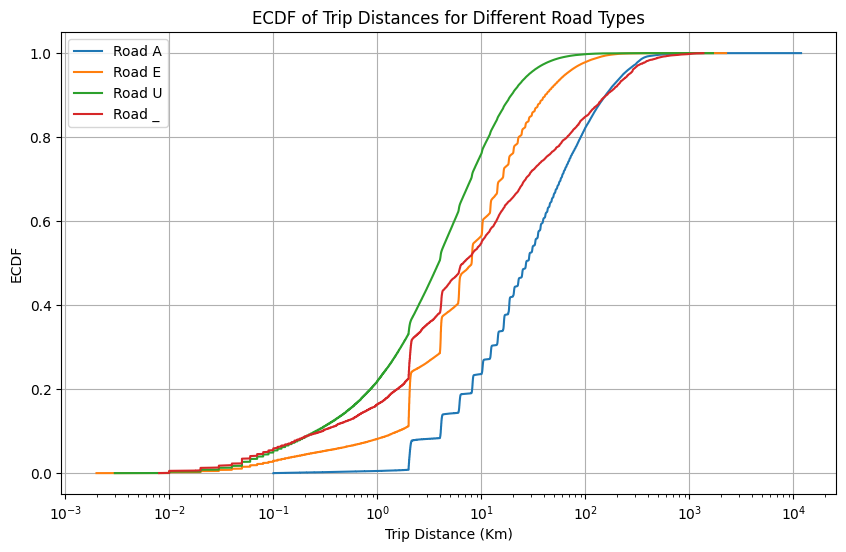

In [2]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

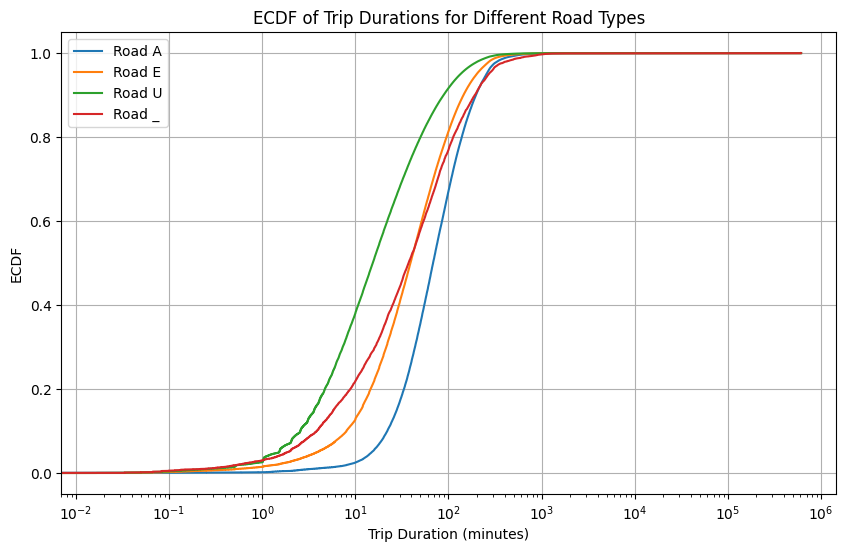

In [3]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

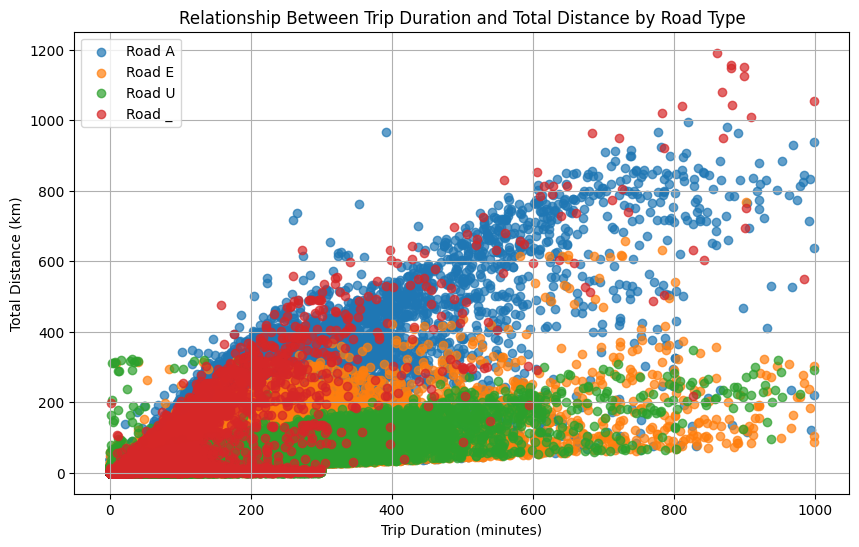

In [4]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grater than 1000 minutes
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

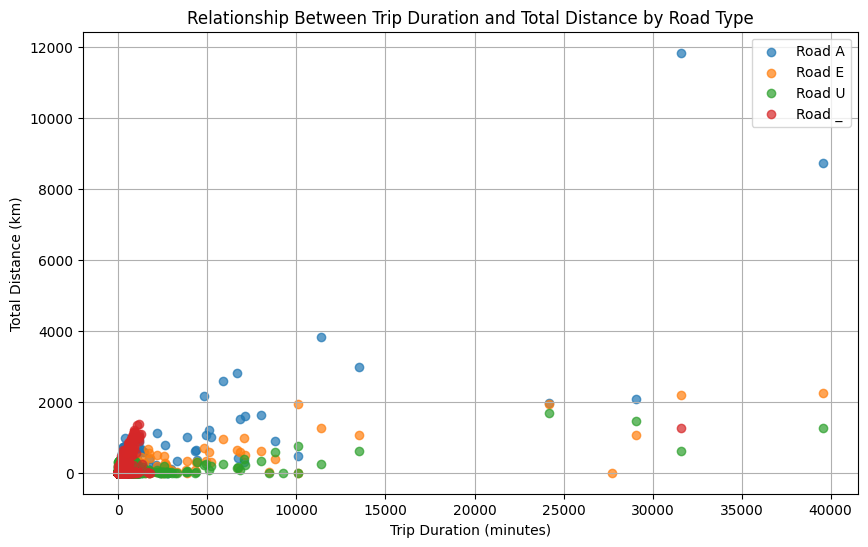

In [5]:
#no filter

data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [7]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 827886


In [8]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828117

# Task 1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("Data/Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 #convert to minutes

data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

1243568 827889


In [10]:
data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = (aggregated["total_driving_time"] / (24 * 60) * 100)  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

overall_stats = aggregated.groupby('day_type').agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

print(overall_stats)


          day_type number_of_trips                   total_travel_distance  \
                              mean median        std                  mean   
0  weekend/holiday       13.327564   10.0  19.269604            300.014054   
1          workday       15.364827   12.0  16.464647            394.703687   

                      utilization_percentage                        
   median         std                   mean     median        std  
0  277.90  225.716945              61.713881  59.914931  41.326510  
1  338.09  252.380491              78.183851  76.541667  38.297247  


In [11]:
from datetime import timedelta

# Function to split trips that span multiple days
def split_trip(row):
    trips = []
    start_time = row['start_time']
    stop_time = row['stop_time']
    total_distance = row['total_distance']
    trip_duration = row['trip_duration']
    
    
    while start_time.date() != stop_time.date():
        end_of_day = start_time.replace(hour=23, minute=59, second=59)
        duration = (end_of_day - start_time).total_seconds() / 60.0
        proportion = duration / trip_duration
        distance = total_distance * proportion
        
        trips.append({
            'vehicle_id': row['vehicle_id'],
            'trip_id': row['trip_id'],
            'start_time': start_time,
            'stop_time': end_of_day,
            'road': row['road'],
            'total_distance': distance,
            'trip_duration': duration,
            'date': start_time.date()
        })
        
        start_time = end_of_day + timedelta(seconds=1)
        trip_duration -= duration
        total_distance -= distance
        
        duration = (stop_time - start_time).total_seconds() / 60.0
        proportion = duration / trip_duration
        distance = total_distance * proportion
        
        trips.append({
            'vehicle_id': row['vehicle_id'],
            'trip_id': row['trip_id'],
            'start_time': start_time,
            'stop_time': stop_time,
            'road': row['road'],
            'total_distance': distance,
            'trip_duration': duration,
            'date': start_time.date()
        })
    
    return trips

split_trips = []
for _, row in data.iterrows():
    if row['start_time'].date() != row['stop_time'].date():        
        split_trips.extend(split_trip(row))
    else:
        split_trips.append(row.to_dict())

split_data = pd.DataFrame(split_trips)
split_data.shape[0]


1267764

In [12]:
split_data["date"] = split_data["start_time"].dt.date
aggregated = split_data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = (aggregated["total_driving_time"] / (24 * 60) * 100)  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

overall_stats = aggregated.groupby('day_type').agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()
print("Statistics with splitted trips")
print(overall_stats)



Statistics with splitted trips
          day_type number_of_trips                   total_travel_distance  \
                              mean median        std                  mean   
0  weekend/holiday       13.590673   10.0  19.299539            301.177156   
1          workday       15.518473   13.0  16.472392            393.516977   

                          utilization_percentage                        
       median         std                   mean     median        std  
0  282.174661  221.382068              62.131008  60.989583  40.769086  
1  337.573500  248.782041              77.882603  76.358218  37.725892  


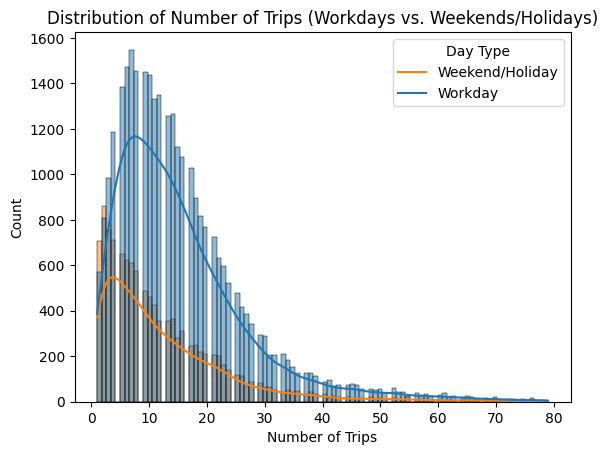

In [13]:
import seaborn as sns
hist_data = aggregated[aggregated['number_of_trips'] < 80]
hist_data = hist_data[hist_data['utilization_percentage'] <= 100]
hist_data = hist_data[hist_data['total_travel_distance'] <= 1200]
sns.histplot(data=hist_data, x='number_of_trips', hue='day_type', kde=True)
plt.title('Distribution of Number of Trips (Workdays vs. Weekends/Holidays)')
plt.xlabel('Number of Trips')
plt.legend(title='Day Type', labels=[ 'Weekend/Holiday', 'Workday'])
plt.show()

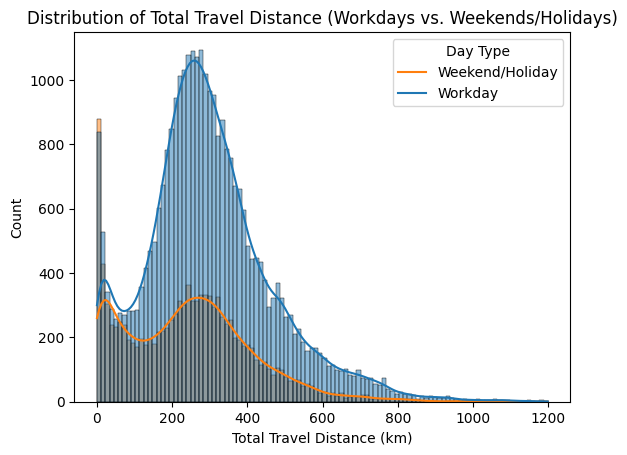

In [14]:
sns.histplot(data=hist_data, x='total_travel_distance', hue='day_type', kde=True)
plt.title('Distribution of Total Travel Distance (Workdays vs. Weekends/Holidays)')
plt.xlabel('Total Travel Distance (km)')
plt.ylabel('Count')
plt.legend(title='Day Type', labels=[ 'Weekend/Holiday', 'Workday'])
plt.show()

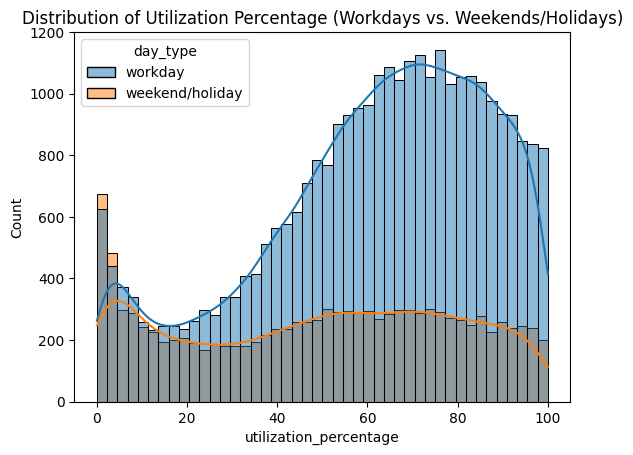

In [15]:
sns.histplot(data=hist_data, x='utilization_percentage', hue='day_type', kde=True)
plt.title('Distribution of Utilization Percentage (Workdays vs. Weekends/Holidays)')
plt.show()

In [16]:
avg_utilization = hist_data.groupby(['vehicle_id', 'day_type'])['utilization_percentage'].mean().unstack()

avg_utilization['difference'] = abs(avg_utilization['workday'] - avg_utilization['weekend/holiday'])

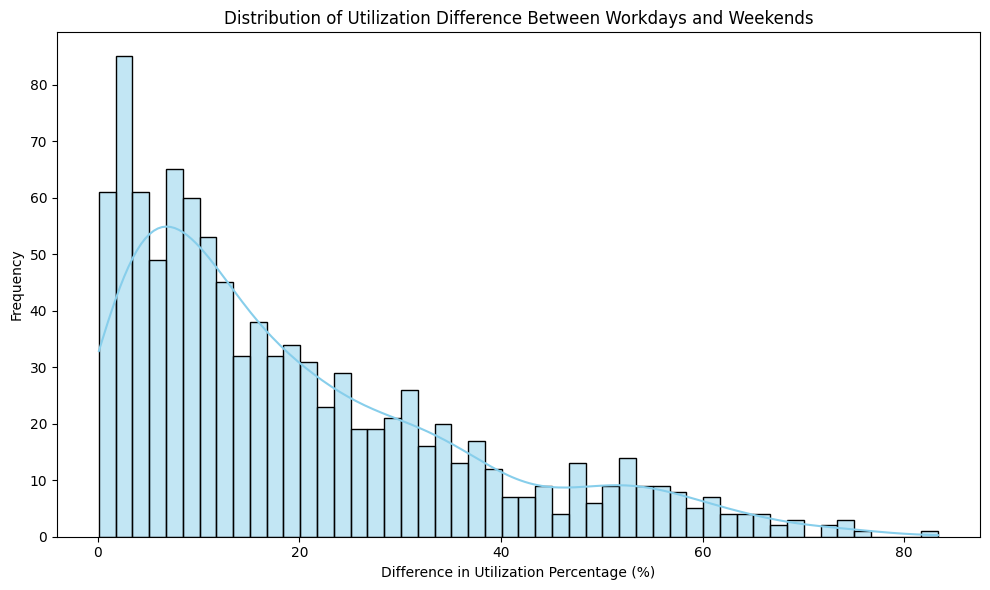

In [17]:

plt.figure(figsize=(10, 6))
sns.histplot(avg_utilization['difference'], bins=50, kde=True, color='skyblue')

plt.title('Distribution of Utilization Difference Between Workdays and Weekends')
plt.xlabel('Difference in Utilization Percentage (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

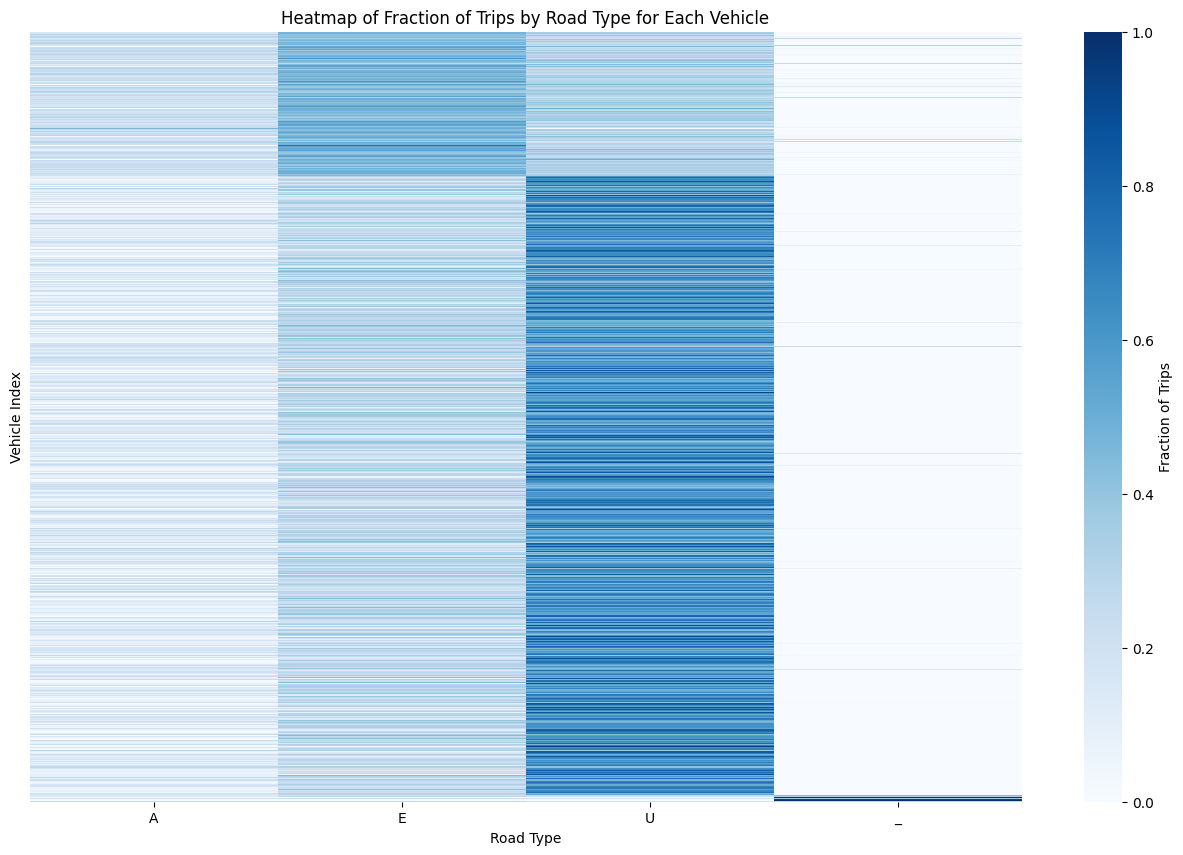

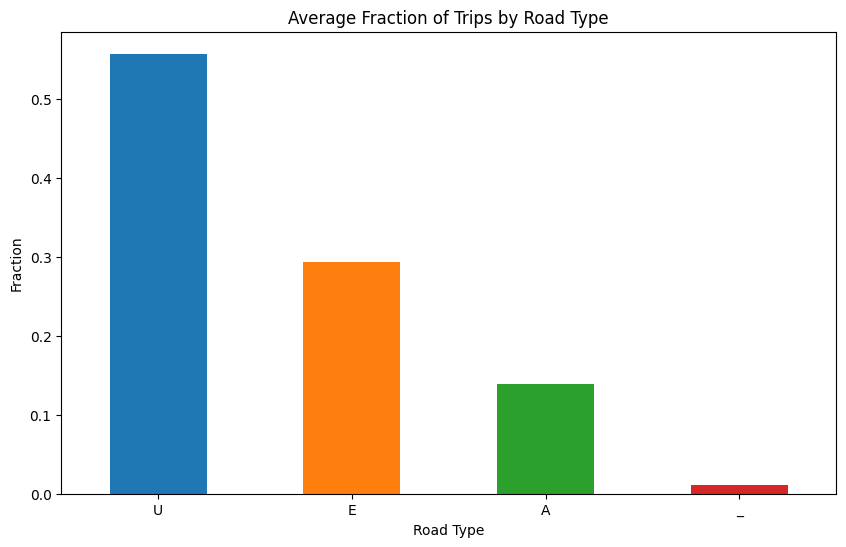

In [ ]:

import seaborn as sns
vehicles = data[data["vehicle_id"].isin(data["vehicle_id"].unique())] #[:1000]
vehicles = vehicles[vehicles["vehicle_id"] != 539]

road_type_counts = vehicles.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)
road_type_counts = road_type_counts[(road_type_counts.sum(axis=1) > 0)]
road_type_fractions = road_type_counts.div(road_type_counts.sum(axis=1), axis=0)

road_type_fractions['Dominant_Road'] = road_type_fractions.idxmax(axis=1)
road_type_fractions = road_type_fractions.sort_values(by='Dominant_Road').drop(columns='Dominant_Road')

plt.figure(figsize=(16, 10))
sns.heatmap(
    road_type_fractions,
    cmap="Blues",
    cbar_kws={'label': 'Fraction of Trips'},
    xticklabels=True,
    yticklabels=False
)

plt.title("Heatmap of Fraction of Trips by Road Type for Each Vehicle")
plt.xlabel("Road Type")
plt.ylabel("Vehicle Index")
plt.show()


road_type_averages = road_type_fractions.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
road_type_averages.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title("Average Fraction of Trips by Road Type")
plt.ylabel("Fraction")
plt.xlabel("Road Type")
plt.xticks(rotation=0)
plt.show()


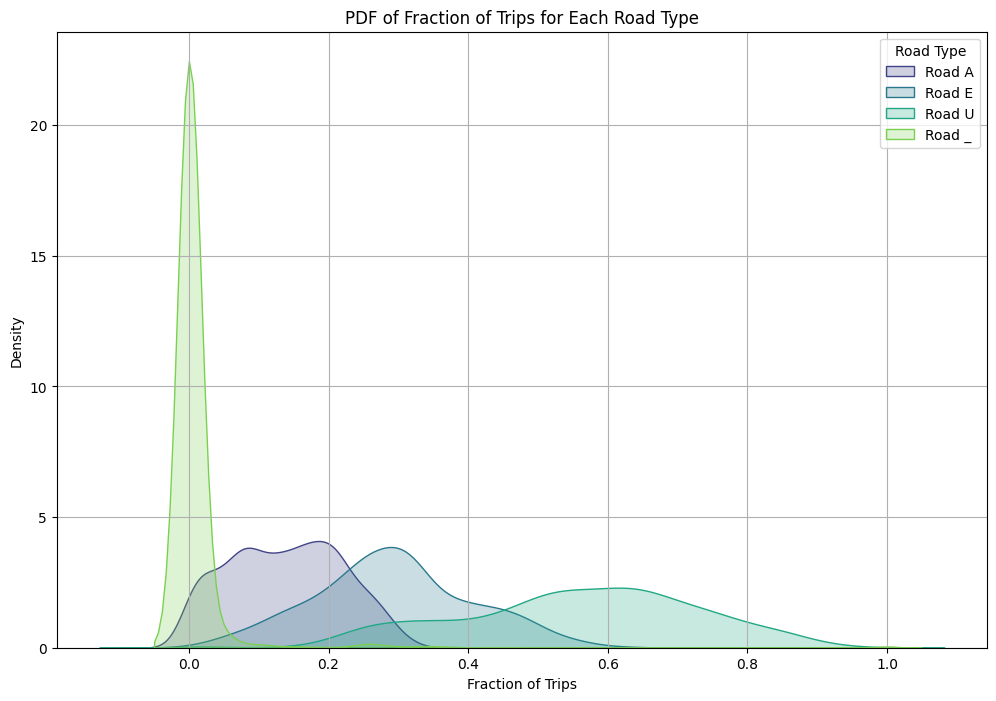

In [ ]:
road_type_fractions = road_type_counts.div(road_type_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(road_type_fractions.columns))

for road_type, color in zip(road_type_fractions.columns, colors):
    sns.kdeplot(road_type_fractions[road_type], label=f"Road {road_type}", shade=True, color=color)

plt.xlabel("Fraction of Trips")
plt.ylabel("Density")
plt.title("PDF of Fraction of Trips for Each Road Type")
plt.legend(title="Road Type")
plt.grid(True)
plt.show()

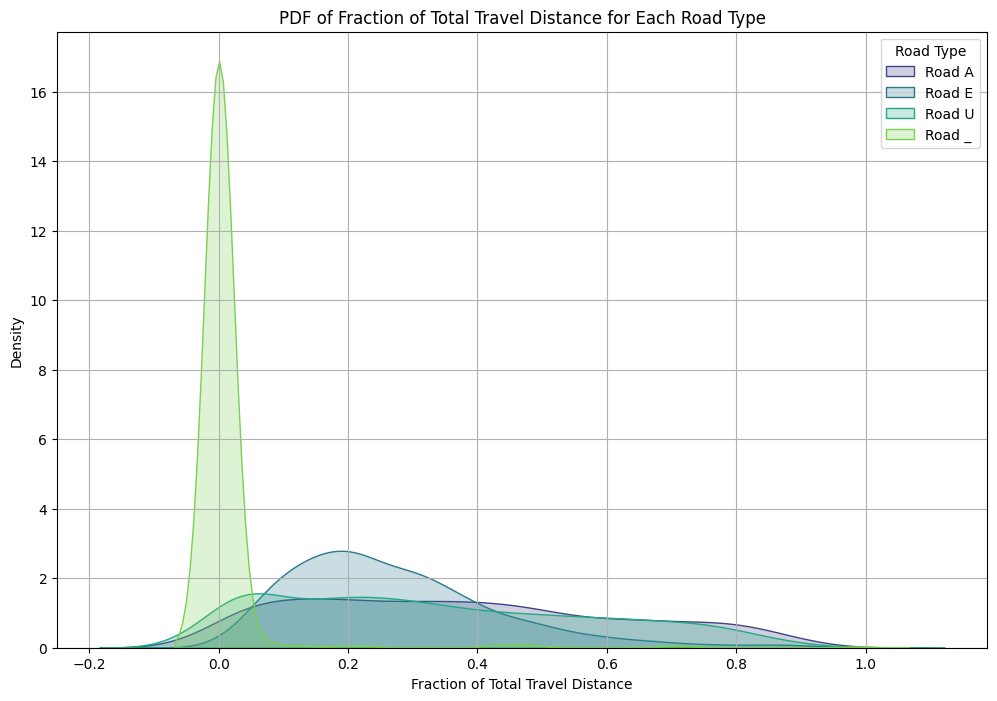

In [ ]:
road_type_distance = vehicles.groupby(["vehicle_id", "road"])["total_distance"].sum().unstack(fill_value=0)

road_type_distance_fractions = road_type_distance.div(road_type_distance.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(road_type_distance_fractions.columns))
for road_type, color in zip(road_type_distance_fractions.columns, colors):
    sns.kdeplot(road_type_distance_fractions[road_type], label=f"Road {road_type}", fill=True, color=color)

plt.xlabel("Fraction of Total Travel Distance")
plt.ylabel("Density")
plt.title("PDF of Fraction of Total Travel Distance for Each Road Type")
plt.legend(title="Road Type")
plt.grid(True)
plt.show()

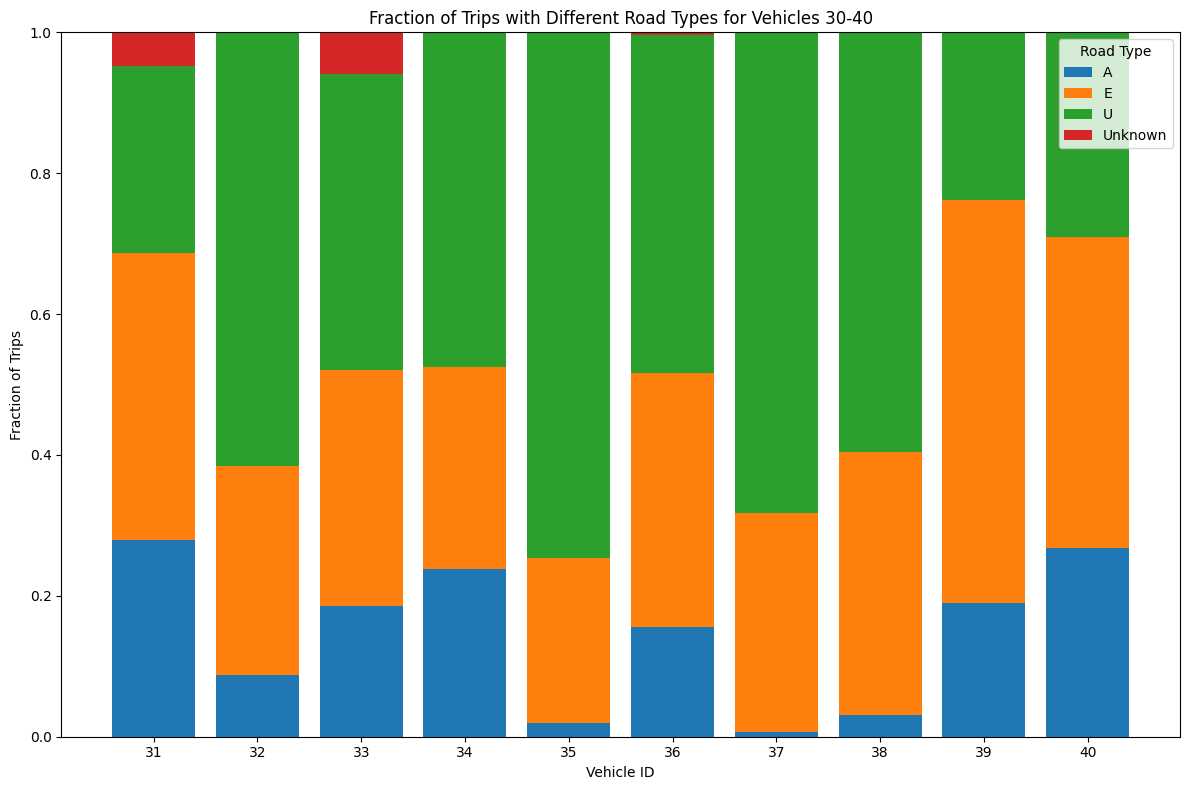

In [21]:
road_type_counts = vehicles.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)
road_type_counts = road_type_counts[30:40]

fig, ax = plt.subplots(figsize=(12, 8))

road_types = road_type_counts.columns
bottom = np.zeros(len(road_type_counts))

for road_type in road_types:
    if road_type == "_":
        label = "Unknown"
    else:
        label = road_type
    ax.bar(road_type_counts.index, road_type_counts[road_type] / road_type_counts.sum(axis=1), bottom=bottom, label=label)
    bottom += road_type_counts[road_type] / road_type_counts.sum(axis=1)

ax.set_title("Fraction of Trips with Different Road Types for Vehicles 30-40")
ax.set_ylabel("Fraction of Trips")
ax.set_xlabel("Vehicle ID")
ax.set_xticks(road_type_counts.index)
ax.legend(title="Road Type")
plt.tight_layout()
plt.show()

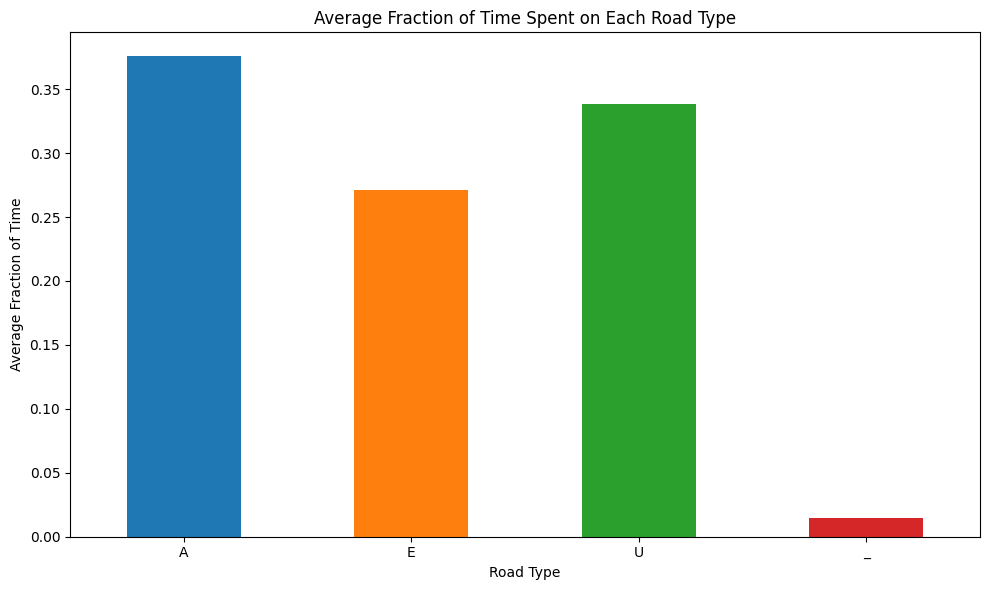

In [22]:
average_time_fractions = road_type_distance_fractions.mean()

plt.figure(figsize=(10, 6))
average_time_fractions.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title("Average Fraction of Time Spent on Each Road Type")
plt.ylabel("Average Fraction of Time")
plt.xlabel("Road Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.cluster import KMeans

# Example: cluster vehicles based on average # of trips/day, avg distance/day, fraction of trips on road 'A', etc.
vehicle_agg = (
    data.groupby("vehicle_id")
    .agg(
        avg_trips_per_day=("trip_id", lambda x: x.nunique() / ( (data["date"].max() - data["date"].min()).days + 1 )),
        avg_distance_per_day=("total_distance", lambda x: x.sum()   / ( (data["date"].max() - data["date"].min()).days + 1 )),
        fraction_road_A=("road", lambda x: np.mean(x == "A")),
        fraction_road_U=("road", lambda x: np.mean(x == "U")),
        fraction_road_E=("road", lambda x: np.mean(x == "E")),
    )
)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
vehicle_agg["cluster"] = kmeans.fit_predict(vehicle_agg)

print(vehicle_agg.head(10))


            avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
vehicle_id                                                             
1                    1.055670             54.675518         0.173256   
2                    0.585567             69.839629         0.256781   
3                    0.777320             72.234994         0.231190   
4                    0.981443             30.013979         0.075472   
5                    0.595876             71.547485         0.208413   
6                    1.952577             56.204386         0.123804   
7                    2.820619             29.781278         0.137626   
8                    0.785567             36.102412         0.051237   
9                    1.082474             34.237505         0.167832   
10                   1.672165             29.729938         0.096261   

            fraction_road_U  fraction_road_E  cluster  
vehicle_id                                             
1                  0.35

In [24]:
cluster_names = {
    0: "Urban Short Trips",
    1: "Highway Long Distances",
    2: "Frequent Commuters"
}
print("Cluster centers:")
print(kmeans.cluster_centers_)
cluster_profiles = vehicle_agg.groupby("cluster").mean()
print(cluster_profiles)

Cluster centers:
[[ 1.91624666 34.19045633  0.10672655  0.63981633  0.24962052]
 [ 1.01077048 74.63873117  0.21973982  0.35081449  0.39465651]
 [ 1.41251359 53.82338527  0.19102547  0.42058809  0.36887921]]
         avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
cluster                                                             
0                 1.916247             34.190456         0.106727   
1                 1.010770             74.638731         0.219740   
2                 1.412514             53.823385         0.191025   

         fraction_road_U  fraction_road_E  
cluster                                    
0               0.639816         0.249621  
1               0.350814         0.394657  
2               0.420588         0.368879  


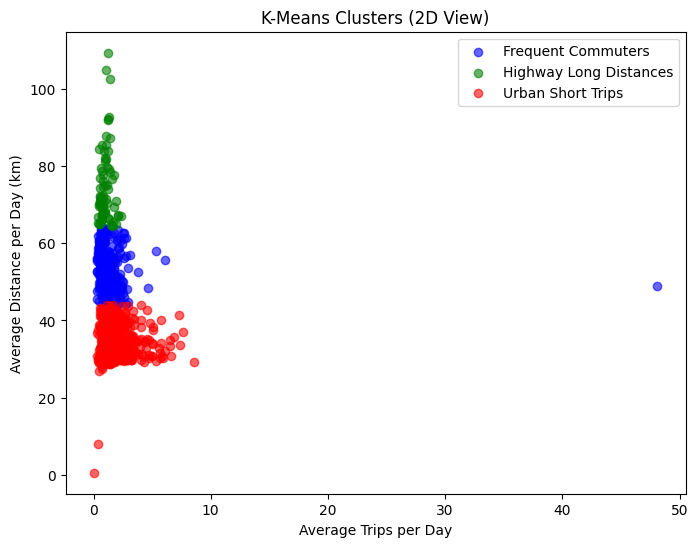

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = {0: "red", 1: "green", 2: "blue"}  

for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(
        subset["avg_trips_per_day"],
        subset["avg_distance_per_day"],
        c=colors[cluster_id],
        label=cluster_names[cluster_id],
        alpha=0.6
    )

ax.set_xlabel("Average Trips per Day")
ax.set_ylabel("Average Distance per Day (km)")
ax.set_title("K-Means Clusters (2D View)")
ax.legend()
plt.show()

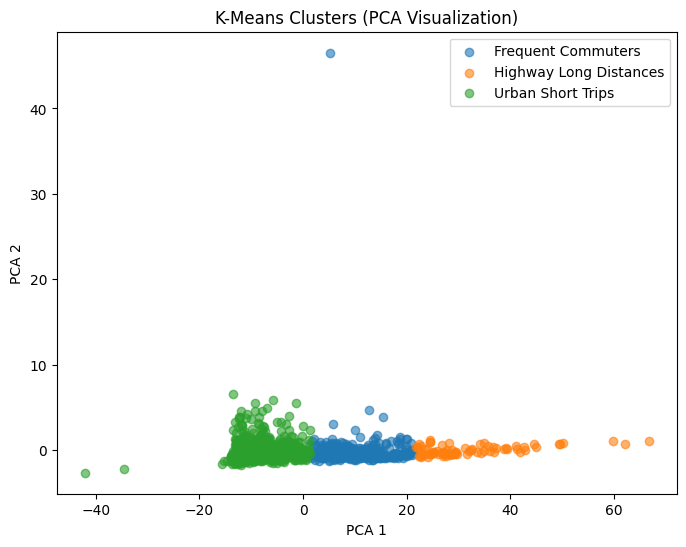

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = vehicle_agg[["avg_trips_per_day", "avg_distance_per_day", 
                 "fraction_road_A", "fraction_road_U", "fraction_road_E"]]

pca_result = pca.fit_transform(X)
vehicle_agg["pca1"] = pca_result[:, 0]
vehicle_agg["pca2"] = pca_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(subset["pca1"], subset["pca2"], 
               label=cluster_names[cluster_id], alpha=0.6)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("K-Means Clusters (PCA Visualization)")
ax.legend()
plt.show()

# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time

In [27]:
import json

cars = {
  "cars": {
    "Tesla Model 3": {
      "cost": 40990, #EUR Germany
      "range_km": 420,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 137, #Wh/km
        "charging_time": 6
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 201,
        "total_power_kw": 208,
        "total_torque_nm": 420,
        "drive": "Rear"
      },
      "battery": {
        "nominal_capacity_kwh": 60.0,
        "useable_capacity_kwh": 57.5,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "6h15m",
          "charge_speed_kmh": 68
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 170,
          "charge_power_10_80_kw_dc": 108,
          "charge_time_min": 24,
          "charge_speed_kmh": 730
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 149,
        "highway_cold_weather_wh_km": 189,
        "combined_cold_weather_wh_km": 167,
        "city_mild_weather_wh_km": 93,
        "highway_mild_weather_wh_km": 142,
        "combined_mild_weather_wh_km": 116
      }
    },
    "BMW iX xDrive40": {
      "cost": 77300, #EUR Germany
      "range_km": 360,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 200, #Wh/km
        "charging_time": 8
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 200,
        "total_power_kw": 240,
        "total_torque_nm": 630,
        "drive": "All-Wheel Drive"
      },
      "battery": {
        "nominal_capacity_kwh": 76.6,
        "useable_capacity_kwh": 71,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "8h",
          "charge_speed_kmh": 45
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 150,
          "charge_power_10_80_kw_dc": 110,
          "charge_time_min": 31,
          "charge_speed_kmh": 580
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 180,
        "highway_cold_weather_wh_km": 220,
        "combined_cold_weather_wh_km": 200,
        "city_mild_weather_wh_km": 140,
        "highway_mild_weather_wh_km": 180,
        "combined_mild_weather_wh_km": 160
      }
    },
    "Citroen e-C3": {
      "cost": 23300, #EUR Germany
      "range_km": 260,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 150, #Wh/km
        "charging_time": 7
      },
      "performance": {
        "acceleration_0_100_kmh": "9.7 sec",
        "top_speed_kmh": 150,
        "total_power_kw": 100,
        "total_torque_nm": 260,
        "drive": "Front"
      },
      "battery": {
        "nominal_capacity_kwh": 50,
        "useable_capacity_kwh": 45,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 7.4,
          "charge_time_h": "7h",
          "charge_speed_kmh": 37
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 100,
          "charge_power_10_80_kw_dc": 75,
          "charge_time_min": 30,
          "charge_speed_kmh": 520
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 160,
        "highway_cold_weather_wh_km": 200,
        "combined_cold_weather_wh_km": 180,
        "city_mild_weather_wh_km": 120,
        "highway_mild_weather_wh_km": 160,
        "combined_mild_weather_wh_km": 140
      }
    }
  }
}



task 3

+-------------------+       +-------------------+       +-------------------+
| Define EVs & Trips| ----> | Replicate Trips   | ----> | Generate Report   |
+-------------------+       +-------------------+       +-------------------+
                               |
                               v
                        +-------------------+
                        | Simulate Consumption |
                        +-------------------+

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])

data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0
weather = "mild" #mild or cold
charging_type = "home_destination" #fast_charging or home_destination
vehicle_data = data.groupby("vehicle_id")
price_fast_charging = 0.5 #EUR per kWh
price_home_charging = 0.15 #EUR per kWh
for car, specs in cars["cars"].items():
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]   #  kWh 
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id, trips in vehicle_data:
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0  
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds()/60 #minutes 
                if time_since_last_stop > 20:
                    
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60 #max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time= time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time
                    
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  #  Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))
    
    feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
    #energy_consumption_per_100km = energy_consumed_100km / total_trips if total_trips > 0 else 0
    charge_time = np.mean(total_charge_time) 
    hours, minutes = divmod(charge_time, 60)  # hours and minutes
    avg_kwh = np.mean(kwh_after_trip)
    energy_consumed_100km = np.mean(energy_consumed)/np.mean(distance_trips)*1000
    


    print(f"----------------------------------------"*3)
    print(f"Feasible trips for {car}: {feasible_percentage:.2f}%")
    #print(f"Energy consumption per 100 km for {car}: {energy_consumption_per_100km:.2f} Wh/km")
    print(f"Average charge time for {car}: {int(hours)} hours and {int(minutes)} minutes (considering only trips that needed to charge)")
    print(f"Avarage SoC after trip for {car}: {avg_kwh:.2f} kWh, Soc percentage: {avg_kwh/battery_capacity*100:.2f}%")
    print(f"Energy consumption per 100 km for {car}: {energy_consumed_100km:.2f} kWh")
    print(f"Avarage cost by buying {car} and driving {np.mean(distance_vehicles)} Km in 2 months: \n-energy: {np.mean(energy_vehicles)*price_fast_charging:.2f} EUR \n-car: {specs['cost']:.2f} EUR")
            

------------------------------------------------------------------------------------------------------------------------
Feasible trips for Tesla Model 3: 89.81%
Average charge time for Tesla Model 3: 2 hours and 20 minutes (considering only trips that needed to charge)
Avarage SoC after trip for Tesla Model 3: 41.40 kWh, Soc percentage: 72.00%
Energy consumption per 100 km for Tesla Model 3: 117.54 kWh
Avarage cost by buying Tesla Model 3 and driving 16847.150263263266 Km in 2 months: 
-energy: 990.13 EUR 
-car: 40990.00 EUR
------------------------------------------------------------------------------------------------------------------------
Feasible trips for BMW iX xDrive40: 86.46%
Average charge time for BMW iX xDrive40: 3 hours and 8 minutes (considering only trips that needed to charge)
Avarage SoC after trip for BMW iX xDrive40: 47.76 kWh, Soc percentage: 67.26%
Energy consumption per 100 km for BMW iX xDrive40: 160.11 kWh
Avarage cost by buying BMW iX xDrive40 and driving 161

In [ ]:
#e
#TO DELETEEEE
weather = "mild"  # mild or cold
charging_type = "home_destination"  # fast_charging or home_destination
price_fast_charging = 0.5  # EUR per kWh
price_home_charging = 0.15  # EUR per kWh
def simulate_cluster(cluster_vehicle_ids, car, specs):
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]  # kWh
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id in cluster_vehicle_ids:
        trips = data[data["vehicle_id"] == vehicle_id]
        remaining_kwh = battery_capacity
        total_charge_time = 0
        distance_vehicle = []
        energy_vehicle = []
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds() / 60  # minutes
                if time_since_last_stop > 20:
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60  # max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop / 60
                        else:
                            charge_time = (battery_capacity - remaining_kwh) / specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop / 60
                        else:
                            charge_time = (battery_capacity - remaining_kwh) / specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time

            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  # Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))

    feasible_percentage = ((feasible_trips - non_feasible) / total_trips) * 100 if total_trips > 0 else 0
    charge_time = np.mean(total_charge_time)
    hours, minutes = divmod(charge_time, 60)  # hours and minutes
    avg_kwh = np.mean(kwh_after_trip)
    energy_consumed_100km = np.mean(energy_consumed) / np.mean(distance_trips) * 1000

    return {
        "feasible_percentage": feasible_percentage,
        "average_charge_time": f"{int(hours)} hours and {int(minutes)} minutes",
        "average_soc_after_trip": avg_kwh,
        "soc_percentage": avg_kwh / battery_capacity * 100,
        "energy_consumption_per_100km": energy_consumed_100km,
        "average_energy_cost": np.mean(energy_vehicles) * price_home_charging,
        "car_cost": specs['cost']
    }

for road_type, vehicle_ids in clusters.items():
    print(f"Performance metrics for cluster {road_type}:")
    for car, specs in cars["cars"].items():
        metrics = simulate_cluster(vehicle_ids, car, specs)
        print(f"Car: {car}")
        print(f"Feasible trips: {metrics['feasible_percentage']:.2f}%")
        print(f"Average charge time: {metrics['average_charge_time']} (considering only trips that needed to charge)")
        print(f"Average SoC after trip: {metrics['average_soc_after_trip']:.2f} kWh, SoC percentage: {metrics['soc_percentage']:.2f}%")
        print(f"Energy consumption per 100 km: {metrics['energy_consumption_per_100km']:.2f} kWh")
        print(f"Average energy cost: {metrics['average_energy_cost']:.2f} EUR")
        print(f"Car cost: {metrics['car_cost']:.2f} EUR")
        print(f"----------------------------------------")


NameError: name 'clusters' is not defined